In [1]:
# Import required funtions and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone
import math
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve
)

In [2]:
# Inspect the data to determine which variables are categorical. These will be changed to numeric later
performance_factors_df = pd.read_csv("StudentPerformanceFactorsCleaned.csv")
performance_factors_df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Female,70


We are going to try to predict school type again.

In [3]:
# Determine what the categories to encode are
print("The unique values of Parental_Involvement are: ", performance_factors_df.Parental_Involvement.unique())
print("The unique values of Access_to_Resources are: ", performance_factors_df.Access_to_Resources.unique())
print("The unique values of Extracurricular_Activities are: ", performance_factors_df.Extracurricular_Activities.unique())
print("The unique values of Motivation_Level are: ", performance_factors_df.Motivation_Level.unique())
print("The unique values of Internet_Access are: ", performance_factors_df.Internet_Access.unique())
print("The unique values of Family_Income are: ", performance_factors_df.Family_Income.unique())
print("The unique values of Teacher_Quality are: ", performance_factors_df.Teacher_Quality.unique())
print("The unique values of School_Type are: ", performance_factors_df.School_Type.unique())
print("The unique values of Peer_Influence are: ", performance_factors_df.Peer_Influence.unique())
print("The unique values of Learning_Disabilities are: ", performance_factors_df.Learning_Disabilities.unique())
print("The unique values of Parental_Education_Level are: ", performance_factors_df.Parental_Education_Level.unique())
print("The unique values of Gender are: ", performance_factors_df.Gender.unique())

The unique values of Parental_Involvement are:  ['Low' 'Medium' 'High']
The unique values of Access_to_Resources are:  ['High' 'Medium' 'Low']
The unique values of Extracurricular_Activities are:  ['No' 'Yes']
The unique values of Motivation_Level are:  ['Low' 'Medium' 'High']
The unique values of Internet_Access are:  ['Yes' 'No']
The unique values of Family_Income are:  ['Low' 'Medium' 'High']
The unique values of Teacher_Quality are:  ['Medium' 'High' 'Low']
The unique values of School_Type are:  ['Public' 'Private']
The unique values of Peer_Influence are:  ['Positive' 'Negative' 'Neutral']
The unique values of Learning_Disabilities are:  ['No' 'Yes']
The unique values of Parental_Education_Level are:  ['High School' 'College' 'Postgraduate']
The unique values of Gender are:  ['Male' 'Female']


In [4]:
# Define a numeric encoding of all categories
# Categories with a low, medium, high metric were arranged ordianlly rather than one-hot encoded
encode_nums = {"Parental_Involvement":       {"Low": 0, "Medium": 1, "High": 2},
               "Access_to_Resources":        {"Low": 0, "Medium": 1, "High": 2},
               "Extracurricular_Activities": {"No": 0, "Yes": 1},
               "Motivation_Level":           {"Low": 0, "Medium": 1, "High": 2},
               "Internet_Access":            {"No": 0, "Yes": 1},
               "Family_Income":              {"Low": 0, "Medium": 1, "High": 2},
               "Teacher_Quality":            {"Low": 0, "Medium": 1, "High": 2},
               "Peer_Influence":             {"Negative": -1, "Neutral": 0, "Positive": 1},
               "Learning_Disabilities":      {"No": 0, "Yes": 1},
               "Parental_Education_Level":   {"High School": 0, "College": 1, "Postgraduate": 2},
               "Gender":                     {"Male": 0, "Female": 1}}

# Apply the encoding and inspect the data
encoded_performance_factors_df = performance_factors_df.replace(encode_nums)
encoded_performance_factors_df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Gender,Exam_Score
0,23,84,0,2,0,7,73,0,1,0,0,1,Public,1,3,0,0,0,67
1,19,64,0,1,0,8,59,0,1,2,1,1,Public,-1,4,0,1,1,61
2,24,98,1,1,1,7,91,1,1,2,1,1,Public,0,4,0,2,0,74
3,29,89,0,1,1,8,98,1,1,1,1,1,Public,-1,4,0,0,0,71
4,19,92,1,1,1,6,65,1,1,3,1,2,Public,0,4,0,1,1,70


In [5]:
# Separate into feature and target variables
X = encoded_performance_factors_df.drop(columns=["School_Type"])
y = encoded_performance_factors_df["School_Type"]

# Split into training, testing, and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=80514, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=182512, stratify=y_test)

# Noramalize the data by dividing by the standard deviation
# We don't need to adjust the mean because that term will cancel out when calculating the distance
# Euclidean distance is shift invariant
normalizer = X_train.std()
X_train = X_train / normalizer
X_val   = X_val   / normalizer
X_test  = X_test  / normalizer

In [6]:
# Do KNN, I wrote this function myself before realizing that there's a library to do it for me
# This function computes the distance between two values
def euclid_dist(x, y):
    acc = 0
    for i in range(len(x)):
        acc += (x.iloc[i]-y.iloc[i])*(x.iloc[i]-y.iloc[i])
    return math.sqrt(acc)

# This funciton computes the nearest neighbors and takes returns plurality value of the target variable
def KNN(row, X, y, dist, k=1):
    # Initialize empty lists of the distances to the point, the index in the array, and the value of the target
    distances = []
    indicies = []
    values = []

    # Fill the lists with default values
    for i in range(k):
        distances.append(float("inf"))
        indicies.append(None)
        values.append(None)
    
    # Loop through the data passed in
    for j in range(len(y)):
        # Take the most distanct neighbor that is one of the k nearest so far
        i = np.argmax(distances)
        distance = dist(X.iloc[j], row)

        # If the new point is closer, update the k nearest so far
        if distance < distances[i]:
            distances[i] = distance
            indicies[i] = j
            values[i] = y.iloc[j]
    dictionary = {}

    # Count th number of each class in the k nearest neighbors
    for i in range(k):
        if not values[i] in dictionary:
            dictionary[values[i]] = 1
        else:
            dictionary[values[i]] += 1
    
    # Return a plurality value from the dictionary
    return max(dictionary, key=dictionary.get)

KNN(X_val.iloc[0], X_train, y_train, euclid_dist, k=3)

'Public'

In [7]:
# Experiment with different choices of k
k_choices = range(1,100,2)

# I deided that precision was the best metric to use to determine the best value of k
# becuase this model has a serious problem with false positives (public schools) in KNN
best_precision = 0
best_k = 0
for k in k_choices:
    # Train a model with variable k
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)

    # Get the confusion matrix values
    conf_matrix = confusion_matrix(y_val, model.predict(X_val))
    TN, FP = conf_matrix[0]
    FN, TP = conf_matrix[1]

    # Compute precision and save the best k in terms of precision
    precision = TP / (TP + FP)
    if best_precision < precision:
        best_precision = precision
        best_k = k

print("The best value of k, measured by precision is: ", best_k)

The best value of k, measured by precision is:  5


Precision was chosen as the measure to determine the optimal value of k after testing several measures of performance. Over the course of exploring these different metrics, it was observed that false positives were a huge issue with the model. Therefore, precision was chosen since it punishes false positives the most harshly since there is extreme class imbalance. None of the performance metrics tried were particularly good, so something had to be chosen and precision seemed to handle the false positive issue the best.

In [8]:
# Define a classifier and print the confusion matrix for the training data
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
conf_matrix = confusion_matrix(y_train, model.predict(X_train))
print("Confusion Matrix:")
print(conf_matrix)

# Get the values from the confusion matrix
TN, FP = conf_matrix[0]
FN, TP = conf_matrix[1]

# Compute accuracy, error, true positive rate, true negative rate, and f1 score
# The formula for f1 score was taken from Wikipedia
accuracy = (TP + TN) / (TP + TN + FP + FN)
prediction_error = 1 - accuracy
true_positive_rate = TP / (TP + FN)
true_negative_rate = TN / (TN + FP)
f1 = 2*TP / (2*TP + FP + FN)

# Print the values in a nice format
print(f"Prediction Accuracy: {accuracy:.4f}")
print(f"Prediction Error: {prediction_error:.4f}")
print(f"True Positive Rate (Recall): {true_positive_rate:.4f}")
print(f"True Negative Rate (Specificity): {true_negative_rate:.4f}")
print(f"F1 Score: {f1:.4f}")

Confusion Matrix:
[[ 424  757]
 [ 219 2465]]
Prediction Accuracy: 0.7475
Prediction Error: 0.2525
True Positive Rate (Recall): 0.9184
True Negative Rate (Specificity): 0.3590
F1 Score: 0.8347


This is a decent accuracy and error value, about 75%. However, this is the training set, so this is likely a case of overfitting. In fact, if we use the validation set instead, accuracy drops dramatically to about 63%.

The recall is quite good, over 90%, but the specificity is not, only about 35%. This is likely a result of class imbalance. Again, testing with the validation set instead, gives much worse values for each, 83% and 19% respectively.

The F1 score is about 83%, again a good score, but when testing on the validation set instead we have only 76%. This isn't too bad of a drop, but it still indicates overfitting.

Fold: 1
AUC: 0.5265
Accuracy: 0.6416
Fold: 2
AUC: 0.5449
Accuracy: 0.6470
Fold: 3
AUC: 0.5182
Accuracy: 0.6284
Fold: 4
AUC: 0.4991
Accuracy: 0.6250
Fold: 5
AUC: 0.5074
Accuracy: 0.6312


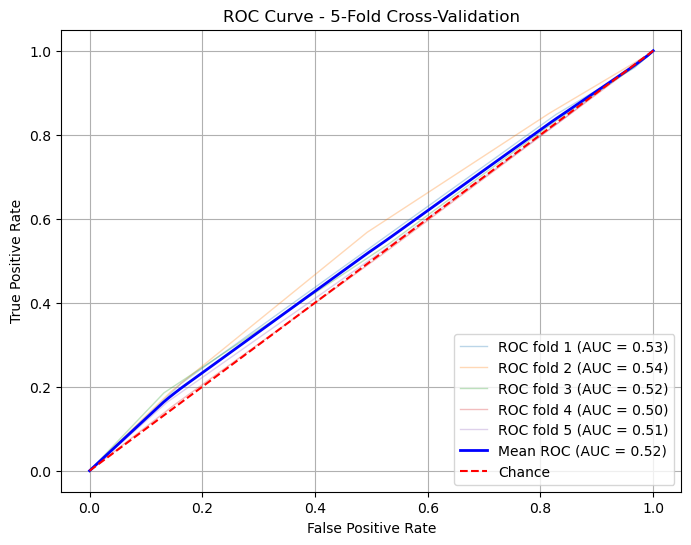


Mean AUC: 0.5192
Mean Accuracy: 0.6346


In [9]:
"""
Most of the code here was reused from last week.
"""

# Initialize the StratifiedKFold
skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create lists to store AUC and accuracy for each fold
auc_scores = []
accuracy_scores = []
mean_fpr = np.linspace(0, 1, 100)
tprs = []

# Start the plot for ROC curves
plt.figure(figsize=(8, 6))

# Iterate over each fold
i = 1
for train_index, test_index in skfolds.split(X, y):
    # Clone the model to ensure fresh fitting for each fold
    clone_knn = clone(model)

    # Split the data into training and testing based on the current fold
    X_train_folds = X.iloc[train_index]
    y_train_folds = y.iloc[train_index]
    X_test_fold = X.iloc[test_index]
    
    # Fit the model on the training data
    clone_knn.fit(X_train_folds, y_train_folds)
    
    # Predict probabilities for the positive class
    y_probs = clone_knn.predict_proba(X_test_fold)[:, 1]
    
    # Predict class labels
    y_pred = clone_knn.predict(X_test_fold)

    # Calculate the AUC for this fold
    auc_sample = roc_auc_score(y.iloc[test_index], y_probs)
    auc_scores.append(auc_sample)
    
    # Calculate the accuracy for this fold
    acc_sample = accuracy_score(y.iloc[test_index], y_pred)
    accuracy_scores.append(acc_sample)

    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(y.iloc[test_index], y_probs, pos_label="Public")

    # Interpolate the ROC curve for consistent plotting
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    # Plot the ROC curve for this fold
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {auc_sample:.2f})')
    
    # Print results for the current fold
    print(f'Fold: {i}')
    print(f'AUC: {auc_sample:.4f}')
    print(f'Accuracy: {acc_sample:.4f}')
    
    i += 1

# Mean ROC curve calculation
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(auc_scores)

# Plot the mean ROC curve
plt.plot(mean_fpr, mean_tpr, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

# Plot the diagonal line (chance)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Chance')

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - 5-Fold Cross-Validation')
plt.legend(loc='lower right')
plt.grid(True)

# Show the ROC curve plot
plt.show()

# Print the mean AUC and accuracy
print(f"\nMean AUC: {mean_auc:.4f}")
print(f"Mean Accuracy: {np.mean(accuracy_scores):.4f}")

The AUC and accuracy do not vary much among the folds. We think it is therefore likely that these differences are little more than noise. In fact, there likely isn't enough evidence to justify that the expected AUC is more than 50%. The accuracy is about the same among all folds as well, about 63%, and there isn't convincing evidence that the differences are more than noise. In fact, the average accuracy is actually worse than simply predicitng "Public" for every school type.